https://colab.research.google.com/drive/1qQs1H3XgLC6rxQzQjj-V5DP-n7-cCpnJ?usp=sharing

##Importing libraries and setting directories

In [3]:
!pip install timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 16.5 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylin

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/SimCLR

/content/drive/MyDrive/SimCLR


In [4]:
## Standard libraries
import os
from copy import deepcopy
import random
from PIL import Image
from torch.utils.data import Dataset
import numpy as np
import timm
from collections import OrderedDict

## Imports for plotting
import matplotlib.pyplot as plt
plt.set_cmap('cividis')
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf') # For export
import matplotlib
matplotlib.rcParams['lines.linewidth'] = 2.0
import seaborn as sns
sns.set()

## tqdm for loading bars
from tqdm.notebook import tqdm

## PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim

## Torchvision
import torchvision
import torchvision.transforms as transforms

# PyTorch Lightning
try:
    import pytorch_lightning as pl
except ModuleNotFoundError: # Google Colab does not have PyTorch Lightning installed by default. Hence, we do it here if necessary
    !pip install --quiet pytorch-lightning>=1.4
    import pytorch_lightning as pl
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint

# Path to the folder where the datasets are/should be downloaded
RDATASET_PATH = './Datasets/NCT-CRC-HE'
SDATASET_PATH = './Datasets/Synthetic_images'
# Path to the folder where the pretrained models are saved
CHECKPOINT_PATH = './Checkpoints'

NUM_WORKERS = os.cpu_count()

# Setting the seed
pl.seed_everything(42)

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print("Device:", device)
print("Number of workers:", NUM_WORKERS)

<ipython-input-4-0318b8730ecb>:16: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg', 'pdf') # For export
INFO:lightning_fabric.utilities.seed:Seed set to 42


Device: cuda:0
Number of workers: 8


<Figure size 640x480 with 0 Axes>

## Data Augmentation for Contrastive Learning



In [5]:
class ContrastiveTransformations(object):

    def __init__(self, base_transforms, n_views=2):
        self.base_transforms = base_transforms
        self.n_views = n_views

    def __call__(self, x):
        return [self.base_transforms(x) for i in range(self.n_views)]

In [ ]:
contrast_transforms = transforms.Compose([transforms.RandomResizedCrop(size=224),
                                          transforms.RandomHorizontalFlip(),
                                          transforms.RandomApply([
                                              transforms.ColorJitter(brightness=0.5,
                                                                     contrast=0.5,
                                                                     saturation=0.5,
                                                                     hue=0.1)
                                          ], p=0.8),
                                          transforms.RandomGrayscale(p=0.2),
                                          transforms.GaussianBlur(kernel_size=9),
                                          transforms.ToTensor(),
                                          transforms.Normalize((0.5,), (0.5,))
                                         ])

## Dataloader functions for real and synthetic images

In [6]:
class MyCustomMixedDataset(Dataset):
    def __init__(self, real_root_dir, synthetic_root_dir, split='unlabeled', transform=None, target_transform=None, seed=42):
        """
        Args:
            real_root_dir (string): Directory with all the real images across multiple subdirectories.
            synthetic_root_dir (string): Directory with all the synthetic images across multiple subdirectories.
            split (str, optional): Which subset of the dataset to use ('train', 'test', 'unlabeled').
            transform (callable, optional): Optional transform to be applied on a PIL image.
            target_transform (callable, optional): Optional transform to be applied on the target.
            seed (int): Random seed for ensuring reproducibility.
        """
        # Set random seeds for reproducibility
        random.seed(seed)
        torch.manual_seed(seed)

        self.real_root_dir = real_root_dir
        self.synthetic_root_dir = synthetic_root_dir
        self.split = split
        self.transform = transform
        self.target_transform = target_transform
        self.image_files = []
        self.labels = []
        self.class_names = ['ADI', 'BACK', 'DEB', 'LYM', 'MUC', 'MUS', 'NORM', 'STR', 'TUM']

        # Collect synthetic and real images
        for class_name in self.class_names:
            self.collect_images(self.synthetic_root_dir, class_name, file_extension='.png', start_index = 0, end_index = 4000)
            self.collect_images(self.real_root_dir, class_name, file_extension='.tif', start_index = 4001, end_index = 8000)

        # Pair the images with their labels
        image_label_pairs = list(zip(self.image_files, self.labels))

        # Shuffle the pairs
        random.shuffle(image_label_pairs)

        # Unzip the shuffled pairs back into images and labels
        self.image_files, self.labels = zip(*image_label_pairs)
        self.image_files = list(self.image_files)
        self.labels = list(self.labels)

        # Select the appropriate split
        if self.split == 'train':
            self.image_files = self.image_files[:2500]
            self.labels = self.labels[:2500]
        elif self.split == 'test':
            self.image_files = self.image_files[2500:4000]
            self.labels = self.labels[2500:4000]
        elif self.split == 'unlabeled':
            self.image_files = self.image_files[4000:]
            self.labels = [-1] * len(self.image_files)

    def collect_images(self, root_dir, class_name, file_extension, start_index=0, end_index=None):
        class_dir = os.path.join(root_dir, class_name)
        if os.path.isdir(class_dir):
            class_images = [os.path.join(class_dir, f) for f in os.listdir(class_dir) if f.endswith(file_extension)]
            class_images = class_images[start_index:end_index]
            self.image_files.extend(class_images)
            for img_path in class_images:
                self.labels.append(self.class_names.index(class_name))

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
      img_name = self.image_files[idx]
      image = Image.open(img_name).convert('RGB')
      target = self.labels[idx]

      image = transforms.Resize(224)(image)

      if self.transform:
        image = self.transform(image)

      return image, target


In [11]:
class MyCustomRealDataset(Dataset):
    def __init__(self, real_root_dir, split='unlabeled', transform=None, target_transform=None, seed=42):
        """
        Args:
            real_root_dir (string): Directory with all the real images across multiple subdirectories.
            synthetic_root_dir (string): Directory with all the synthetic images across multiple subdirectories.
            split (str, optional): Which subset of the dataset to use ('train', 'test', 'unlabeled').
            transform (callable, optional): Optional transform to be applied on a PIL image.
            target_transform (callable, optional): Optional transform to be applied on the target.
            seed (int): Random seed for ensuring reproducibility.
        """
        # Set random seeds for reproducibility
        random.seed(seed)
        torch.manual_seed(seed)

        self.real_root_dir = real_root_dir
       # self.synthetic_root_dir = synthetic_root_dir
        self.split = split
        self.transform = transform
        self.target_transform = target_transform
        self.image_files = []
        self.labels = []
        self.class_names = ['ADI', 'BACK', 'DEB', 'LYM', 'MUC', 'MUS', 'NORM', 'STR', 'TUM']

        # Collect synthetic and real images
        for class_name in self.class_names:
           # self.collect_images(self.synthetic_root_dir, class_name, file_extension='.png', start_index = 0, end_index = 4000)
            self.collect_images(self.real_root_dir, class_name, file_extension='.tif', start_index = 0, end_index = 5000)

        # Pair the images with their labels
        image_label_pairs = list(zip(self.image_files, self.labels))

        # Shuffle the pairs
        random.shuffle(image_label_pairs)

        # Unzip the shuffled pairs back into images and labels
        self.image_files, self.labels = zip(*image_label_pairs)
        self.image_files = list(self.image_files)
        self.labels = list(self.labels)

        # Select the appropriate split
        if self.split == 'train':
            self.image_files = self.image_files[:2500]
            self.labels = self.labels[:2500]
        elif self.split == 'test':
            self.image_files = self.image_files[2500:4000]
            self.labels = self.labels[2500:4000]
        elif self.split == 'unlabeled':
            self.image_files = self.image_files[4000:]
            self.labels = [-1] * len(self.image_files)

    def collect_images(self, root_dir, class_name, file_extension, start_index=0, end_index=None):
        class_dir = os.path.join(root_dir, class_name)
        if os.path.isdir(class_dir):
            class_images = [os.path.join(class_dir, f) for f in os.listdir(class_dir) if f.endswith(file_extension)]
            class_images = class_images[start_index:end_index]
            self.image_files.extend(class_images)
            for img_path in class_images:
                self.labels.append(self.class_names.index(class_name))

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
      img_name = self.image_files[idx]
      image = Image.open(img_name).convert('RGB')
      target = self.labels[idx]

      image = transforms.Resize(224)(image)

      if self.transform:
        image = self.transform(image)

      return image, target


In [ ]:
#Comment if want to use real dataset
unlabeled_data = MyCustomMixedDataset(real_root_dir=RDATASET_PATH, synthetic_root_dir=SDATASET_PATH, split='unlabeled',
                       transform=ContrastiveTransformations(contrast_transforms, n_views=2))
train_data_contrast = MyCustomMixedDataset(real_root_dir=RDATASET_PATH, synthetic_root_dir=SDATASET_PATH, split='train',
                       transform=ContrastiveTransformations(contrast_transforms, n_views=2))

In [ ]:
#Uncomment if want to use real dataset

# unlabeled_data = MyCustomRealDataset(real_root_dir=RDATASET_PATH, split='unlabeled',
#                        transform=ContrastiveTransformations(contrast_transforms, n_views=2))
# train_data_contrast = MyCustomRealDataset(real_root_dir=RDATASET_PATH, split='train',
#                        transform=ContrastiveTransformations(contrast_transforms, n_views=2))

INFO:lightning_fabric.utilities.seed:Seed set to 42


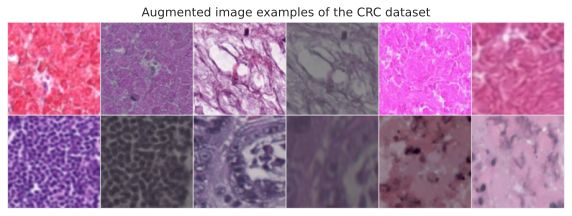

In [ ]:
# Visualize some examples
pl.seed_everything(42)
NUM_IMAGES = 6
imgs = torch.stack([img for idx in range(NUM_IMAGES) for img in unlabeled_data[idx][0]], dim=0)
img_grid = torchvision.utils.make_grid(imgs, nrow=6, normalize=True, pad_value=0.9)
img_grid = img_grid.permute(1, 2, 0)

plt.figure(figsize=(10,5))
plt.title('Augmented image examples of the CRC dataset')
plt.imshow(img_grid)
plt.axis('off')
plt.show()
plt.close()

## ViT Encoder

In [7]:
class VisionEncoder(nn.Module):
    def __init__(self,
                 # vision
                 vision_width: int,
                 vision_model: nn.Module,
                 # ssl
                 ssl_mlp_dim: int,
                 ssl_emb_dim: int,
                 **kwargs,
                 ):
        super().__init__()

        self.vision_width = vision_width
        self.visual = vision_model

        self.image_mlp = nn.Sequential(OrderedDict([
            ("layer1", nn.Linear(vision_width, ssl_mlp_dim)),
            ("bn1", nn.SyncBatchNorm(ssl_mlp_dim)),
            ("relu1", nn.ReLU(inplace=True)),
            ("layer2", nn.Linear(ssl_mlp_dim, ssl_mlp_dim)),
            ("bn2", nn.SyncBatchNorm(ssl_mlp_dim)),
            ("relu2", nn.ReLU(inplace=True)),
            ("layer3", nn.Linear(ssl_mlp_dim, ssl_emb_dim)),
        ]))

    def forward(self, images, **kwargs):
      h = self.visual(images)
      h = self.image_mlp(h)

      return h

## SimCLR implementation

In [8]:
class SimCLR(pl.LightningModule):

    def __init__(self, output_dim, hidden_dim, lr, temperature, weight_decay, max_epochs=500):
        super().__init__()
        self.save_hyperparameters()
        assert self.hparams.temperature > 0.0, 'The temperature must be a positive float!'

        # Vit-B/16 backbone
        vision_model = timm.create_model('vit_base_patch16_224', num_classes=0)
        self.backbone = VisionEncoder(vision_width=768, vision_model=vision_model,
                              ssl_mlp_dim=hidden_dim, ssl_emb_dim=output_dim)

    def configure_optimizers(self):
        optimizer = optim.AdamW(self.parameters(),
                                lr=self.hparams.lr,
                                weight_decay=self.hparams.weight_decay)
        lr_scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer,
                                                            T_max=self.hparams.max_epochs,
                                                            eta_min=self.hparams.lr/50)
        return [optimizer], [lr_scheduler]

    def info_nce_loss(self, batch, mode='train'):
        imgs, _ = batch
        imgs = torch.cat(imgs, dim=0)

        # Encode all images
        feats = self.backbone(imgs)

        # Calculate cosine similarity
        cos_sim = F.cosine_similarity(feats[:,None,:], feats[None,:,:], dim=-1)
        # Mask out cosine similarity to itself
        self_mask = torch.eye(cos_sim.shape[0], dtype=torch.bool, device=cos_sim.device)
        cos_sim.masked_fill_(self_mask, -9e15)
        # Find positive example -> batch_size//2 away from the original example
        pos_mask = self_mask.roll(shifts=cos_sim.shape[0]//2, dims=0)
        # InfoNCE loss
        cos_sim = cos_sim / self.hparams.temperature
        nll = -cos_sim[pos_mask] + torch.logsumexp(cos_sim, dim=-1)
        nll = nll.mean()

        # Logging loss
        self.log(mode+'_loss', nll)
        # Get ranking position of positive example
        comb_sim = torch.cat([cos_sim[pos_mask][:,None],  # First position positive example
                              cos_sim.masked_fill(pos_mask, -9e15)],
                             dim=-1)
        sim_argsort = comb_sim.argsort(dim=-1, descending=True).argmin(dim=-1)
        # Logging ranking metrics
        self.log(mode+'_acc_top1', (sim_argsort == 0).float().mean())
        self.log(mode+'_acc_top5', (sim_argsort < 5).float().mean())
        self.log(mode+'_acc_mean_pos', 1+sim_argsort.float().mean())

        return nll

    def training_step(self, batch, batch_idx):
        return self.info_nce_loss(batch, mode='train')

    def validation_step(self, batch, batch_idx):
        self.info_nce_loss(batch, mode='val')

## Training

In [ ]:
def train_simclr(batch_size, max_epochs=500, **kwargs):

    # Set up checkpoint callback to save the best model
    checkpoint_callback = ModelCheckpoint(
        dirpath=os.path.join(CHECKPOINT_PATH, 'SimCLR'),
        filename='best-checkpoint',
        save_top_k=3,
        verbose=True,
        monitor='val_loss',
        mode='min'
    )

    # Trainer configuration
    trainer = pl.Trainer(
        default_root_dir=os.path.join(CHECKPOINT_PATH, 'SimCLR'),
        accelerator="gpu" if str(device).startswith("cuda") else "cpu",
        devices=1,
        max_epochs=max_epochs,
        callbacks=[checkpoint_callback, LearningRateMonitor('epoch')]
    )


    train_loader = data.DataLoader(unlabeled_data, batch_size=batch_size, shuffle=True,
                                       drop_last=True, pin_memory=True, num_workers=NUM_WORKERS)
    val_loader = data.DataLoader(train_data_contrast, batch_size=batch_size, shuffle=False,
                                     drop_last=False, pin_memory=True, num_workers=NUM_WORKERS)

    # Set random seed for reproducibility
    pl.seed_everything(42)

    # Initialize model
    model = SimCLR(max_epochs=max_epochs, **kwargs)
    trainer.fit(model, train_loader, val_loader)

    # Load best model after training
    model = SimCLR.load_from_checkpoint(checkpoint_callback.best_model_path)

    return model


In [ ]:
simclr_model = train_simclr(batch_size=32,
                            hidden_dim=1024,
                            output_dim=256,
                            lr=5e-4,
                            temperature=0.07,
                            weight_decay=1e-4,
                            max_epochs=25)

## Logistic Regression

In [9]:
class LogisticRegression(pl.LightningModule):

    def __init__(self, feature_dim, num_classes, lr, weight_decay, max_epochs=100):
        super().__init__()
        self.save_hyperparameters()
        # Mapping from representation h to classes
        self.model = nn.Linear(feature_dim, num_classes)

    def configure_optimizers(self):
        optimizer = optim.AdamW(self.parameters(),
                                lr=self.hparams.lr,
                                weight_decay=self.hparams.weight_decay)
        lr_scheduler = optim.lr_scheduler.MultiStepLR(optimizer,
                                                      milestones=[int(self.hparams.max_epochs*0.6),
                                                                  int(self.hparams.max_epochs*0.8)],
                                                      gamma=0.1)
        return [optimizer], [lr_scheduler]

    def _calculate_loss(self, batch, mode='train'):
        feats, labels = batch
        preds = self.model(feats)
        loss = F.cross_entropy(preds, labels)
        acc = (preds.argmax(dim=-1) == labels).float().mean()

        self.log(mode + '_loss', loss)
        self.log(mode + '_acc', acc)
        return loss

    def training_step(self, batch, batch_idx):
        return self._calculate_loss(batch, mode='train')

    def validation_step(self, batch, batch_idx):
        self._calculate_loss(batch, mode='val')

    def test_step(self, batch, batch_idx):
        self._calculate_loss(batch, mode='test')

In [12]:
img_transforms = transforms.Compose([transforms.ToTensor(),
                                     transforms.Normalize((0.5,), (0.5,))])

train_img_data = MyCustomRealDataset(real_root_dir=RDATASET_PATH, split='train',
                       transform=img_transforms)
test_img_data = MyCustomRealDataset(real_root_dir=RDATASET_PATH, split='test',
                       transform=img_transforms)

print("Number of training examples:", len(train_img_data))
print("Number of test examples:", len(test_img_data))

Number of training examples: 2500
Number of test examples: 1500


In [13]:
@torch.no_grad()
def prepare_data_features(model, dataset):
    # Prepare model
    network = deepcopy(model.backbone)
    network.fc = nn.Identity()  # Removing projection head
    network.eval()
    network.to(device)

    # Encode all images
    data_loader = data.DataLoader(dataset, batch_size=64, num_workers=NUM_WORKERS, shuffle=False, drop_last=False)
    feats, labels = [], []
    for batch_imgs, batch_labels in tqdm(data_loader):
        batch_imgs = batch_imgs.to(device)
        batch_feats = network(batch_imgs)
        feats.append(batch_feats.detach().cpu())
        labels.append(batch_labels)

    feats = torch.cat(feats, dim=0)
    labels = torch.cat(labels, dim=0)

    # Sort images by labels
    labels, idxs = labels.sort()
    feats = feats[idxs]

    return data.TensorDataset(feats, labels)

In [14]:
#Choose which model's checkpoints to test
real_images_dir = 'real/best-checkpoint.ckpt'
real_syn_dir = 'real + synthetic/best-checkpoint-v1.ckpt'
synthetic_dir = 'synthetic/best-checkpoint.ckpt'

#Using real+synthetic
best_checkpoint_path = os.path.join(CHECKPOINT_PATH, real_syn_dir)

In [15]:
simclr_model = SimCLR.load_from_checkpoint(best_checkpoint_path)
simclr_model.eval()
simclr_model.to(device)

SimCLR(
  (backbone): VisionEncoder(
    (visual): VisionTransformer(
      (patch_embed): PatchEmbed(
        (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
        (norm): Identity()
      )
      (pos_drop): Dropout(p=0.0, inplace=False)
      (patch_drop): Identity()
      (norm_pre): Identity()
      (blocks): Sequential(
        (0): Block(
          (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (attn): Attention(
            (qkv): Linear(in_features=768, out_features=2304, bias=True)
            (q_norm): Identity()
            (k_norm): Identity()
            (attn_drop): Dropout(p=0.0, inplace=False)
            (proj): Linear(in_features=768, out_features=768, bias=True)
            (proj_drop): Dropout(p=0.0, inplace=False)
          )
          (ls1): Identity()
          (drop_path1): Identity()
          (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (mlp): Mlp(
            (fc1): Linear(in_features=768,

In [ ]:
train_feats_simclr = prepare_data_features(simclr_model, train_img_data)
test_feats_simclr = prepare_data_features(simclr_model, test_img_data)

  0%|          | 0/40 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/24 [00:00<?, ?it/s]

In [ ]:
def train_logreg(batch_size, train_feats_data, test_feats_data, model_suffix, max_epochs=100, **kwargs):
    trainer = pl.Trainer(default_root_dir=os.path.join(CHECKPOINT_PATH, "LogisticRegression"),
                         accelerator="gpu" if str(device).startswith("cuda") else "cpu",
                         devices=1,
                         max_epochs=max_epochs,
                         callbacks=[ModelCheckpoint(save_weights_only=True, mode='max', monitor='val_acc'),
                                    LearningRateMonitor("epoch")],
                         enable_progress_bar=False,
                         check_val_every_n_epoch=10)
    trainer.logger._default_hp_metric = None

    # Data loaders
    train_loader = data.DataLoader(train_feats_data, batch_size=batch_size, shuffle=True,
                                   drop_last=False, pin_memory=True, num_workers=0)
    test_loader = data.DataLoader(test_feats_data, batch_size=batch_size, shuffle=False,
                                  drop_last=False, pin_memory=True, num_workers=0)

    pl.seed_everything(42)  # To be reproducable
    model = LogisticRegression(**kwargs)
    trainer.fit(model, train_loader, test_loader)
    model = LogisticRegression.load_from_checkpoint(trainer.checkpoint_callback.best_model_path)

    # Test best model on train and validation set
    train_result = trainer.test(model, train_loader, verbose=False)
    test_result = trainer.test(model, test_loader, verbose=False)
    result = {"train": train_result[0]["test_acc"], "test": test_result[0]["test_acc"]}

    return model, result

In [ ]:
def get_smaller_dataset(original_dataset, num_imgs_per_label):
    new_dataset = data.TensorDataset(
        *[t.unflatten(0, (10, -1))[:,:num_imgs_per_label].flatten(0, 1) for t in original_dataset.tensors]
    )
    return new_dataset

In [ ]:
results = {}
for num_imgs_per_label in [10, 20, 50, 100, 200, 500]:
    sub_train_set = get_smaller_dataset(train_feats_simclr, num_imgs_per_label)
    _, small_set_results = train_logreg(batch_size=64,
                                        train_feats_data=sub_train_set,
                                        test_feats_data=test_feats_simclr,
                                        model_suffix=num_imgs_per_label,
                                        feature_dim=train_feats_simclr.tensors[0].shape[1],
                                        num_classes=9,
                                        lr=1e-3,
                                        weight_decay=1e-3)
    results[num_imgs_per_label] = small_set_results

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:lightning_fabric.utilities.seed:Seed set to 42
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type   | Params
---------------------------------
0 | model | Linear | 2.3 K 
---------------------------------
2.3 K     Trainable params
0         Non-trainable params
2.3 K     Total params
0.009     Total estimated model params size (MB)
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to 

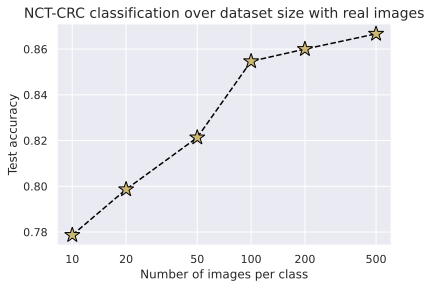

Test accuracy for  10 images per label: 77.87%
Test accuracy for  20 images per label: 79.87%
Test accuracy for  50 images per label: 82.13%
Test accuracy for 100 images per label: 85.47%
Test accuracy for 200 images per label: 86.00%
Test accuracy for 500 images per label: 86.67%


In [ ]:
dataset_sizes = sorted([k for k in results])
test_scores = [results[k]["test"] for k in dataset_sizes]

fig = plt.figure(figsize=(6,4))
plt.plot(dataset_sizes, test_scores, '--', color="#000", marker="*", markeredgecolor="#000", markerfacecolor="y", markersize=16)
plt.xscale("log")
plt.xticks(dataset_sizes, labels=dataset_sizes)
plt.title("NCT-CRC classification over dataset size with real images", fontsize=14)
plt.xlabel("Number of images per class")
plt.ylabel("Test accuracy")
plt.minorticks_off()
plt.show()

for k, score in zip(dataset_sizes, test_scores):
    print(f'Test accuracy for {k:3d} images per label: {100*score:4.2f}%')

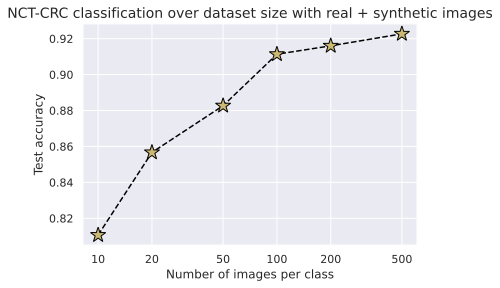

Test accuracy for  10 images per label: 81.07%
Test accuracy for  20 images per label: 85.67%
Test accuracy for  50 images per label: 88.27%
Test accuracy for 100 images per label: 91.13%
Test accuracy for 200 images per label: 91.60%
Test accuracy for 500 images per label: 92.27%


In [ ]:
dataset_sizes = sorted([k for k in results])
test_scores = [results[k]["test"] for k in dataset_sizes]

fig = plt.figure(figsize=(6,4))
plt.plot(dataset_sizes, test_scores, '--', color="#000", marker="*", markeredgecolor="#000", markerfacecolor="y", markersize=16)
plt.xscale("log")
plt.xticks(dataset_sizes, labels=dataset_sizes)
plt.title("NCT-CRC classification over dataset size with real + synthetic images", fontsize=14)
plt.xlabel("Number of images per class")
plt.ylabel("Test accuracy")
plt.minorticks_off()
plt.show()

for k, score in zip(dataset_sizes, test_scores):
    print(f'Test accuracy for {k:3d} images per label: {100*score:4.2f}%')